# Importing libraries

In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt

# Loading the COCO dataset

**Function that return the path of training images**

In [2]:
def TrainImagesPath(path):
    images_path = []
    for file in os.listdir(path):
        if file == "test2017":
            file_path = os.path.join(path, file)
            for f in os.listdir(file_path):
                image_path = os.path.join(file_path, f)
                images_path.append(image_path)
                if len(images_path) == 40000:
                    break
    return images_path

**Getting images paths**

In [3]:
path = "/kaggle/input/coco-2017-dataset/coco2017"
train_images_path = TrainImagesPath(path)

**Creating Custom Dataset and Dataloader**

In [4]:
class CustomDataset(Dataset):
    def __init__(self, images_path, labels, transform=None):
        self.images_path = images_path
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images_path)
        
    def __getitem__(self, idx):
        image = Image.open(self.images_path[idx]).convert('RGB') 
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [5]:
train_transform = transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.CenterCrop((256, 256)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.mul(255))
                                    ])

In [6]:
train_dataset = CustomDataset(train_images_path, [0]*len(train_images_path), train_transform)

In [7]:
len(train_images_path)

40000

In [8]:
batch_size = 4

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

# GPU configuration

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Function to load style image

In [11]:
style_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.mul(255))
                            ])

In [12]:
def LoadStyleImage(path, batch_size, device):
    style = Image.open(path).convert('RGB')
    style = style_transform(style)
    style = style.repeat(batch_size, 1, 1, 1)
    style = style.to(device) 
    return style

# Loading Pretained VGG16 model

In [13]:
class VGG16(nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
            
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [14]:
vgg = VGG16(requires_grad=False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 77.1MB/s]


In [15]:
vgg = vgg.to(device)

# Defining architecture of Transformernet model

In [16]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + x
        return out

In [18]:
class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [19]:
class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        
        self.relu = nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

# Defining training helper functions

In [20]:
def gram_matrix(y):
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram

In [21]:
def normalize_batch(batch):
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

# Training on given style image

In [22]:
def TrainTransformerNet(style_path, vgg, device, train_dataloader, batch_size, epochs=1, lr=1e-3, content_weight = 1e5, style_weight = 1e10):
    
    style_image = LoadStyleImage(style_path, batch_size, device) ## Getting style image
    features_style = vgg(normalize_batch(style_image)) ## getting features maps of style image
    gram_style = [gram_matrix(y) for y in features_style] ## creating gram matrix of style features
    
    transformer = TransformerNet()
    transformer = transformer.to(device)
    optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    loss = []
    style_loss_ = []
    content_loss_ = []
    
    for epoch in range(epochs):
        
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        
        for x, _ in tqdm(train_dataloader):
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = normalize_batch(y)
            x = normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = content_weight * criterion(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            n_batch = len(x)
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += criterion(gm_y, gm_s[:n_batch, :, :])
            style_loss *= style_weight

            total_loss_b = content_loss + style_loss
            total_loss_b.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item() 
            
            style_loss_.append(style_loss.item())
            content_loss_.append(content_loss.item())
            loss.append(style_loss.item() + content_loss.item())
        
        avg_content_loss = agg_content_loss / len(train_dataloader)
        avg_style_loss = agg_style_loss / len(train_dataloader)
        avg_loss = avg_content_loss + avg_style_loss
        
        print(f" {epoch +1} / {epochs} Style Loss : {avg_style_loss:.4f}, Content Loss : {avg_content_loss:.4f}, Total Loss : {avg_loss:.4f}")
            
        
    return transformer, loss, style_loss_, content_loss_

In [23]:
style_name = "American Steam Train Travel"

In [24]:
input_dir = "/kaggle/input/style-images-for-neural-style-transfer/Style Images for Neural Style Transfer"

In [25]:
style_path = os.path.join(input_dir, style_name)
style_path += ".jpg"

In [26]:
trained_model, loss, style_loss, content_loss = TrainTransformerNet(style_path, vgg, device, train_dataloader, batch_size, epochs=1, lr=1e-3, content_weight = 1e5, style_weight = 1e10)

  0%|          | 0/10000 [00:00<?, ?it/s]

 1 / 1 Style Loss : 155936.3755, Content Loss : 283764.0417, Total Loss : 439700.4172


# Plotting losses

In [27]:
def plot_losses(loss, style_loss, content_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(loss, label='Total Loss')
    plt.plot(style_loss, label='Style Loss')
    plt.plot(content_loss, label='Content Loss')
    plt.title('Training Losses')
    plt.xlabel('Per 4 samples')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

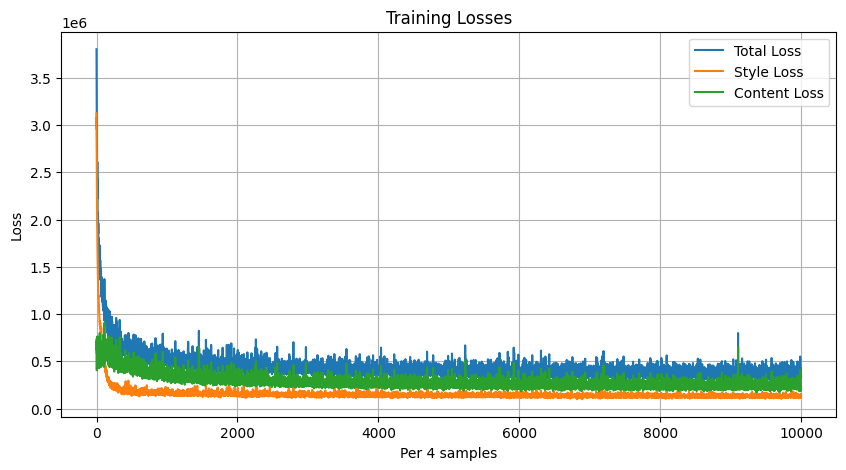

In [28]:
plot_losses(loss, style_loss, content_loss)

# Saving the trained Model

In [29]:
trained_model = trained_model.to("cpu")

In [30]:
model_name = style_name + ".model"

In [31]:
torch.save(trained_model.state_dict(), model_name)